# Particle identification

A classifier is trained to determine the type of particle.
The electron, proton, muon, kaon, pion, and ghost are the six types of particles (another type of particle or detector noise).


In the detector systems or subdetectors, different particle kinds produce distinct reactions.
The tracking system, ring imaging Cherenkov detector, electromagnetic and hadron calorimeters, and muon system are the five systems.



We want to identify a particle type using the responses in the detector systems.

In [1]:
import tensorflow as tf
#from tensorflow import keras
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import random
import time
from sklearn.decomposition import PCA
from keras.layers.core import Activation
from keras.layers import BatchNormalization
from matplotlib import patches
from sklearn import metrics
sns.set(font_scale=2)
np.set_printoptions(formatter={'float':lambda x: ('%10.3f')%(x)}, suppress = True)
pd.options.display.float_format = "{:,.3f}".format
%matplotlib inline

### Import data 

In [2]:
df = pd.read_csv('training.csv.gz')

### Dataset overview

Data taken from here: https://github.com/hse-aml/hadron-collider-machine-learning/releases/tag/Week_2

Spd stands for Scintillating Pad Detector, Prs - Preshower, Ecal - electromagnetic calorimeter, Hcal - hadronic calorimeter, Brem denotes traces of the particles that were deflected by detector.

    ID - id value for tracks (presents only in the test file for the submitting purposes)
    Label - string valued observable denoting particle types. Can take values "Electron", "Muon", "Kaon", "Proton", "Pion" and "Ghost". This column is absent in the test file.
    FlagSpd - flag (0 or 1), if reconstructed track passes through Spd
    FlagPrs - flag (0 or 1), if reconstructed track passes through Prs
    FlagBrem - flag (0 or 1), if reconstructed track passes through Brem
    FlagEcal - flag (0 or 1), if reconstructed track passes through Ecal
    FlagHcal - flag (0 or 1), if reconstructed track passes through Hcal
    FlagRICH1 - flag (0 or 1), if reconstructed track passes through the first RICH detector
    FlagRICH2 - flag (0 or 1), if reconstructed track passes through the second RICH detector
    FlagMuon - flag (0 or 1), if reconstructed track passes through muon stations (Muon)
    SpdE - energy deposit associated to the track in the Spd
    PrsE - energy deposit associated to the track in the Prs
    EcalE - energy deposit associated to the track in the Hcal
    HcalE - energy deposit associated to the track in the Hcal
    PrsDLLbeElectron - delta log-likelihood for a particle candidate to be electron using information from Prs
    BremDLLbeElectron - delta log-likelihood for a particle candidate to be electron using information from Brem
    TrackP - particle momentum
    TrackPt - particle transverse momentum
    TrackNDoFSubdetector1 - number of degrees of freedom for track fit using hits in the tracking sub-detector1
    TrackQualitySubdetector1 - chi2 quality of the track fit using hits in the tracking sub-detector1
    TrackNDoFSubdetector2 - number of degrees of freedom for track fit using hits in the tracking sub-detector2
    TrackQualitySubdetector2 - chi2 quality of the track fit using hits in the tracking sub-detector2
    TrackNDoF - number of degrees of freedom for track fit using hits in all tracking sub-detectors
    TrackQualityPerNDoF - chi2 quality of the track fit per degree of freedom
    TrackDistanceToZ - distance between track and z-axis (beam axis)
    Calo2dFitQuality - quality of the 2d fit of the clusters in the calorimeter
    Calo3dFitQuality - quality of the 3d fit in the calorimeter with assumption that particle was electron
    EcalDLLbeElectron - delta log-likelihood for a particle candidate to be electron using information from Ecal
    EcalDLLbeMuon - delta log-likelihood for a particle candidate to be muon using information from Ecal
    EcalShowerLongitudinalParameter - longitudinal parameter of Ecal shower
    HcalDLLbeElectron - delta log-likelihood for a particle candidate to be electron using information from Hcal
    HcalDLLbeMuon - delta log-likelihood for a particle candidate to be using information from Hcal
    RICHpFlagElectron - flag (0 or 1) if momentum is greater than threshold for electrons to produce Cherenkov light
    RICHpFlagProton - flag (0 or 1) if momentum is greater than threshold for protons to produce Cherenkov light
    RICHpFlagPion - flag (0 or 1) if momentum is greater than threshold for pions to produce Cherenkov light
    RICHpFlagKaon - flag (0 or 1) if momentum is greater than threshold for kaons to produce Cherenkov light
    RICHpFlagMuon - flag (0 or 1) if momentum is greater than threshold for muons to produce Cherenkov light
    RICH_DLLbeBCK - delta log-likelihood for a particle candidate to be background using information from RICH
    RICH_DLLbeKaon - delta log-likelihood for a particle candidate to be kaon using information from RICH
    RICH_DLLbeElectron - delta log-likelihood for a particle candidate to be electron using information from RICH
    RICH_DLLbeMuon - delta log-likelihood for a particle candidate to be muon using information from RICH
    RICH_DLLbeProton - delta log-likelihood for a particle candidate to be proton using information from RICH
    MuonFlag - muon flag (is this track muon) which is determined from muon stations
    MuonLooseFlag muon flag (is this track muon) which is determined from muon stations using looser criteria
    MuonLLbeBCK - log-likelihood for a particle candidate to be not muon using information from muon stations
    MuonLLbeMuon - log-likelihood for a particle candidate to be muon using information from muon stations
    DLLelectron - delta log-likelihood for a particle candidate to be electron using information from all subdetectors
    DLLmuon - delta log-likelihood for a particle candidate to be muon using information from all subdetectors
    DLLkaon - delta log-likelihood for a particle candidate to be kaon using information from all subdetectors
    DLLproton - delta log-likelihood for a particle candidate to be proton using information from all subdetectors
    GhostProbability - probability for a particle candidate to be ghost track. This variable is an output of classification model used in the tracking algorithm.


The difference between log-likelihood that a given track is left by some particle (for example, electron) and log-likelihood that a given track is left by a pion is referred to as delta log-likelihood in the feature descriptions.
This is done because pions leave the majority of tracks (80%), and we need to distinguish other particles from pions.
The null hypothesis states that the particle is a pion. 


In [3]:
pd.set_option('display.max_columns', None)
df.describe()

,TrackP,TrackNDoFSubdetector2,BremDLLbeElectron,MuonLooseFlag,FlagSpd,SpdE,EcalDLLbeElectron,DLLmuon,RICHpFlagElectron,EcalDLLbeMuon,TrackQualitySubdetector2,FlagPrs,DLLelectron,DLLkaon,EcalE,TrackQualityPerNDoF,DLLproton,PrsDLLbeElectron,FlagRICH1,MuonLLbeBCK,FlagHcal,EcalShowerLongitudinalParameter,Calo2dFitQuality,TrackPt,TrackDistanceToZ,RICHpFlagPion,HcalDLLbeElectron,Calo3dFitQuality,FlagEcal,MuonLLbeMuon,TrackNDoFSubdetector1,RICHpFlagProton,RICHpFlagKaon,GhostProbability,TrackQualitySubdetector1,RICH_DLLbeBCK,FlagRICH2,FlagBrem,HcalDLLbeMuon,TrackNDoF,RICHpFlagMuon,RICH_DLLbeKaon,RICH_DLLbeElectron,HcalE,MuonFlag,FlagMuon,PrsE,RICH_DLLbeMuon,RICH_DLLbeProton
count,"1,200,000.000","1,200,000.000","1,200,000.000","1,200,000.000","1,200,000.000","1,200,000.000","1,200,000.000","1,200,000.000","1,200,000.000","1,200,000.000","1,200,000.000","1,200,000.000","1,200,000.000","1,200,000.000","1,200,000.000","1,200,000.000","1,200,000.000","1,200,000.000","1,200,000.000","1,200,000.000","1,200,000.000","1,200,000.000","1,200,000.000","1,200,000.000","1,200,000.000","1,200,000.000","1,200,000.000","1,200,000.000","1,200,000.000","1,200,000.000","1,200,000.000","1,200,000.000","1,200,000.000","1,200,000.000","1,200,000.000","1,200,000.000","1,200,000.000","1,200,000.000","1,200,000.000","1,200,000.000","1,200,000.000","1,200,000.000","1,200,000.000","1,200,000.000","1,200,000.000","1,200,000.000","1,200,000.000","1,200,000.000","1,200,000.000"
mean,"16,141.618",14.752,-207.732,0.191,0.853,-144.385,-182.827,-12.669,0.951,-183.002,16.095,0.851,-14.022,-14.507,"2,346.436",1.283,-14.899,-149.952,0.832,-809.173,0.765,-425.722,-167.267,928.229,0.679,0.859,-235.196,"1,003.778",0.818,-808.715,6.198,0.211,0.406,0.055,6.852,-52.046,0.502,0.792,-235.320,29.422,0.919,-51.838,-51.039,"2,900.030",0.166,0.821,-133.895,-49.200,-52.234
std,"27,903.657",4.038,405.463,0.393,0.354,354.504,385.480,104.916,0.215,385.396,7.771,0.356,104.784,107.432,"5,720.122",0.627,107.398,354.920,0.373,391.154,0.424,"5,214.858",396.827,"1,589.902",1.306,0.348,423.323,"2,408.589",0.386,392.097,3.116,0.408,0.491,0.092,5.072,215.125,0.500,0.406,423.256,6.029,0.273,215.321,215.085,"7,686.446",0.372,0.383,362.898,214.761,215.233
min,"1,115.380",1.000,-999.000,0.000,0.000,-999.000,-999.000,-999.000,0.000,-999.000,0.000,0.000,-999.000,-999.000,-999.000,0.045,-999.000,-999.000,0.000,-999.000,0.000,"-386,169.844",-999.000,1.447,-0.000,0.000,-999.000,-999.000,0.000,-999.000,1.000,0.000,0.000,0.001,0.000,-999.000,0.000,0.000,-999.000,7.000,0.000,-999.000,-999.000,-999.000,0.000,0.000,-999.000,-999.000,-999.000
25%,"4,137.650",13.000,-0.639,0.000,1.000,0.000,-3.001,-5.711,1.000,-3.368,10.711,1.000,-7.061,-10.706,-0.000,0.886,-12.045,-3.063,1.000,-999.000,1.000,-999.000,0.095,268.642,0.283,1.000,-1.926,-999.000,1.000,-999.000,4.000,0.000,0.000,0.004,3.083,-16.205,0.000,1.000,-3.023,26.000,1.000,-14.699,-13.105,-0.000,0.000,1.000,0.000,-4.503,-16.195
50%,"8,069.835",16.000,-0.533,0.000,1.000,3.200,-2.321,-1.988,1.000,-1.956,15.244,1.000,-4.365,0.000,659.098,1.106,0.000,-2.731,1.000,-999.000,1.000,-296.296,0.808,546.222,0.514,1.000,-1.129,128.645,1.000,-999.000,6.000,0.000,0.000,0.010,5.844,-0.000,1.000,1.000,-1.792,30.000,1.000,-0.000,-2.356,578.013,0.000,1.000,2.468,-0.470,-0.000
75%,"17,501.571",18.000,-0.059,0.000,1.000,3.200,0.592,1.669,1.000,0.434,20.407,1.000,0.002,8.464,"3,000.769",1.448,8.914,-1.331,1.000,-999.000,1.000,155.144,4.374,"1,110.635",0.692,1.000,-0.110,"1,658.714",1.000,-999.000,8.000,0.000,1.000,0.055,9.511,8.768,1.000,1.000,0.199,34.000,1.000,8.465,1.674,"3,046.122",0.000,1.000,8.502,1.300,8.922
max,"4,750,951.000",30.000,4.792,1.000,1.000,3.200,4.341,14.711,1.000,2.153,104.863,1.000,17.693,168.170,"315,680.500",4.000,146.298,3.463,1.000,0.023,1.000,"729,387.375",998.403,"427,157.031",42.137,1.000,3.128,"9,999.937",1.000,0.000,24.000,1.000,1.000,0.400,99.148,77.614,1.000,1.000,2.873,52.000,1.000,158.801,186.154,"868,220.000",1.000,1.000,280.580,142.833,146.29

In [4]:
df.shape

(1200000, 50)

In [5]:
#we convert the types of particles to numerical values
dictionary = {'Electron': int(0), 'Ghost': int(1), 'Kaon': int(2), 'Muon': int(3), 'Pion': int(4), 'Proton': int(5)}
df['Class'] = np.array([dictionary[i] for i in df.Label.values])

In [6]:
del df['TrackP']
del df['Label']

## Neural network

we define a function for the artificial neural network

In [9]:
def nn(df, seed, graph, hidden_layer_nodes, initial_learning_rate, epochs, steps):

    data = parse_data(df=df, seed=seed,do_pca =0.9, norm=True) 
    all_data = data.all_data()
        
    # Initialising the NN
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer((df.shape[1]-2,)))
    
    # First hidden layer
    model.add(tf.keras.layers.Dense(units = hidden_layer_nodes, kernel_initializer = 'lecun_uniform', 
                                        use_bias = 'lecun_uniform'))
    model.add(BatchNormalization())
    model.add(Activation('gelu'))
    
    model.add(tf.keras.layers.Dropout(0.2))
    
    model.add(tf.keras.layers.Dense(6))
    model.add(Activation('softmax'))
    
    optimizer = tf.keras.optimizers.Adamax(learning_rate=initial_learning_rate, beta_1 = 0.75, beta_2 = 0.95)    

    loss = tf.keras.losses.SparseCategoricalCrossentropy()

    model.compile(optimizer = 'Adamax', loss = loss,metrics=['accuracy'])
    callback1 = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 3, verbose = 0,
                                                mode = 'min', baseline = None, restore_best_weights = True)
    callback2 = tf.keras.callbacks.TerminateOnNaN()
    history = model.fit(data.train()[0], data.train()[1], batch_size = int(all_data*(0.7/steps)), 
                        steps_per_epoch = steps, validation_data = (data.valid()[0], data.valid()[1]),
                        epochs = epochs, verbose = 1, callbacks = [callback1,callback2])  
    
    if graph == True:
        model.summary()
        plt.figure(figsize = (12,5))
        plt.plot(history.history['loss'], alpha = 0.8, label = 'Train')
        plt.plot(history.history['val_loss'], color = 'magenta', alpha = 0.8, label = 'Test')
        plt.title("Loss over epochs", fontsize = 14)
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend(loc = 'upper left')
        plt.show()
    
    y_pred = np.zeros(data.test()[0].shape[0])
    predictions = model.predict(data.test()[0])
    for i in range(data.test()[0].shape[0]):
        y_pred[i] = np.round(np.argmax(predictions[i]))
    y_test = data.test_unscaled()
    print("Classification accuracy: %0.6f" % metrics.accuracy_score(y_test, y_pred))

    labels = ['0','1','2','3','4','5'] 
    confusion = metrics.multilabel_confusion_matrix(y_pred,y_test)
    cm = metrics.confusion_matrix(y_pred,y_test)
    
    # Plot confusion matrix 
    print("confusion matrix")
    fig = plt.figure(figsize = (18, 10))
    sns.heatmap(cm, annot = True, square = True, cbar = False, xticklabels = labels, yticklabels = labels)
    plt.show()
    

all data: 1.2e+06
Epoch 1/200
1000/1000 [==============================] - 11s 9ms/step - loss: 1.2269 - accuracy: 0.5129 - val_loss: 1.0584 - val_accuracy: 0.5673
Epoch 2/200
1000/1000 [==============================] - 9s 9ms/step - loss: 0.9085 - accuracy: 0.6401 - val_loss: 0.8402 - val_accuracy: 0.6694
Epoch 3/200
1000/1000 [==============================] - 8s 8ms/step - loss: 0.8277 - accuracy: 0.6690 - val_loss: 0.7894 - val_accuracy: 0.6786
Epoch 4/200
1000/1000 [==============================] - 8s 8ms/step - loss: 0.7866 - accuracy: 0.6864 - val_loss: 0.7583 - val_accuracy: 0.7000
Epoch 5/200
1000/1000 [==============================] - 8s 8ms/step - loss: 0.7521 - accuracy: 0.7014 - val_loss: 0.7082 - val_accuracy: 0.7211
Epoch 6/200
1000/1000 [==============================] - 9s 9ms/step - loss: 0.7295 - accuracy: 0.7104 - val_loss: 0.7097 - val_accuracy: 0.7179
Epoch 7/200
1000/1000 [==============================] - 8s 8ms/step - loss: 0.7151 - accuracy: 0.7161 - val_lo

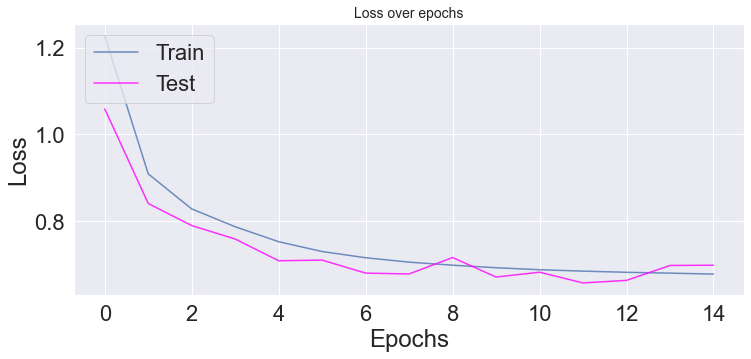

Classification accuracy: 0.738633
confusion matrix


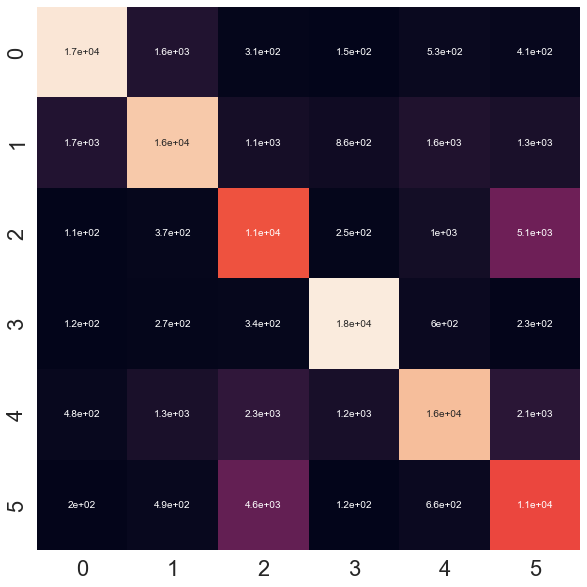

In [11]:
nn(df = df, seed = 134897, graph = True, hidden_layer_nodes=50, initial_learning_rate=0.5, epochs = 200, steps = 1000)      